### Truncated copula MLE

In [1]:
# Load everything - Gamma
%matplotlib inline
from scipy.optimize import dual_annealing
import numpy as np
import scipy.stats as scs
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import Matern
from collections import Counter
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
from tqdm import tqdm
from datetime import datetime
import itertools
from itertools import permutations
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.colors as mcolors
from sklearn import metrics
import pickle
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics.pairwise import rbf_kernel as rbf
from math import sqrt
from joblib import Parallel, delayed
import psutil
import math
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from scipy.sparse import coo_matrix
import scipy.sparse
import warnings
import networkx as nx


#from parallel.backends import BackendDummy as Backend
#backend = Backend()
#################
with open('Data_for_truncated_copula/inv_Us.txt','rb') as f:
    inv_us = pickle.load(f)

with open('Data_for_truncated_copula/did_rain_01.txt','rb') as f:
    did_rain_01 = pickle.load(f)

with open('Data_for_truncated_copula/g2_us.txt','rb') as f:
    g2_us = pickle.load(f)

with open('Data_for_truncated_copula/dist_mat.txt','rb') as f:
    dist_mat = pickle.load(f)

c:\Users\u1819911\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Functions

# MC estimate - Correct and working
def mc_cdf(rvs,cov_matrix,ppf_us):
    '''
    rvs: [[set1], ... , [set m]] each set of length = #locations = n.
    cov_matrix: covariance matrix between the locations in question.
    ppf_us: [u1, ... , un] length = # locs.
    '''    
    # rvs are mean 0 already, but need different covariance
    cholesk_mat = np.linalg.cholesky(cov_matrix)
    normcov_vars = [np.asarray(cholesk_mat@rvs[i])[0] for i in range(len(rvs))]
    out = max(1e-13,np.sum([np.sum([normcov_vars[m][n]<ppf_us[n] for n in range(len(ppf_us))])==len(ppf_us) for m in range(len(normcov_vars))]))
    return out/len(rvs)       

# Truncated Gaussian copula class
class truncgauss():
    def __init__(self,L):
        '''
        Class to fit and work with a truncated Gaussian copula, using two functions.
        sim: simulated [0,1] values using this copula density.
        eval_nll: evaluate the negative log likelihood based on given data.
        To use the class, the dimension of the data is needed.
        n: dimension of data
        '''
        self.L=L
    
    def sim(self,theta,draws):
        '''
        Simulates m draws from the truncated gaussian copula conditional on parameters theta for the covariance kernel.
        '''
        #later

    def nll(self,theta,Invcdf_Us,truncation_pi,did_rain,len_locs,rvs):
        cov_mat = np.nan_to_num(rbf(self.L,gamma=theta),copy=False,nan=0)
        nll=0
        for day in tqdm(range(len(Invcdf_Us))): #eg [251,...,500]
            
            # numerator: joint pdf integrated over truncation - equivalent to elegant normal cdf in some cases. Check cases:
            if np.sum(did_rain[day])==len(did_rain[day]): #all wet, just normal pdf
                nll += scs.multivariate_normal.logpdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)
            else: # some dry -> use elegant cdf
                #print('elegant'+str(np.sum(did_rain[day])))
                if np.sum(did_rain[day])==0: # all dry -> use normal cdf
                    nll += scs.multivariate_normal.logcdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)

                else:
                    
                    # need to re-arrange the covariance matrix into 2*2 blocks based on censored/uncensored. 
                    r_rain,c_rain = [[i] for i in np.nonzero(did_rain[day])[0]],[i for i in np.nonzero(did_rain[day])[0]]
                    r_dry,c_dry = [[i] for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]],[i for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]]
                    
                    # create submatricies
                    submat11 = coo_matrix(cov_mat[r_dry,c_dry])
                    submat12 = csr_matrix(cov_mat[r_dry,c_rain])
                    submat21 = csc_matrix(cov_mat[r_rain,c_dry])
                    submat22 = coo_matrix(cov_mat[r_rain,c_rain])
                    
                    #### MC estimate part      ####

                    if len(submat22.todense())!=1:
                        sub_cov = (submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense()
                    else: # submat22 is an integer, aka only one non-zero obs
                        sub_cov = (submat11-submat12*scipy.sparse.linalg.inv(submat22)[0]*submat21).todense()
                    # Do MC approximation to cdf
                    nll += np.log(mc_cdf([rvs[i][:len(c_dry)] for i in range(len(rvs))],sub_cov,[inv_us[day][k] for k in c_dry]))

                    #### MC estimate part - end ####


                    # compute and add the elegant cdf
                    #if len(submat22.todense())==1:
                    #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12*scipy.sparse.linalg.inv(submat22)[0]*submat21).todense())
                    #else:
                    #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense())
            
            # denominator: multiplication of marginals - pdf for positive rain, cdf for truncated
            for loc in range(len(Invcdf_Us[0])):
                if did_rain[day][loc]==1:# wet: add pdf(invcdf(u_i))
                    nll -= scs.norm.logpdf(Invcdf_Us[day][loc],loc=0,scale=1)
                else:# dry: add cdf(invcdf(pi))
                    nll -= np.log(truncation_pi[day][loc])
            
        return -nll

#function for single nll eval   

def nll_sub_days(days_list,Invcdf_Us,truncation_pi,did_rain,len_locs,rvs,cov_mat):
    
    #warnings.filterwarnings("ignore")

    nll=0
    for day in tqdm(days_list): #eg [251,...,500]
        # numerator: joint pdf integrated over truncation - equivalent to elegant normal cdf in some cases. Check cases:
        if np.sum(did_rain[day])==len(did_rain[day]): #all wet, just normal pdf
            nll += scs.multivariate_normal.logpdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)
        else: # some dry -> use elegant cdf
            #print('elegant'+str(np.sum(did_rain[day])))
            if np.sum(did_rain[day])==0: # all dry -> use normal cdf
                nll += scs.multivariate_normal.logcdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)

            else:
                
                # need to re-arrange the covariance matrix into 2*2 blocks based on censored/uncensored. 
                r_rain,c_rain = [[i] for i in np.nonzero(did_rain[day])[0]],[i for i in np.nonzero(did_rain[day])[0]]
                r_dry,c_dry = [[i] for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]],[i for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]]
                
                # create submatricies
                submat11 = csr_matrix(cov_mat[r_dry,c_dry])
                submat12 = csr_matrix(cov_mat[r_dry,c_rain])
                submat21 = csc_matrix(cov_mat[r_rain,c_dry])
                submat22 = csr_matrix(cov_mat[r_rain,c_rain])
                
                #### MC estimate part      ####

                if len(submat22.todense())!=1:
                    sub_cov = (submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense()
                else: # submat22 is an integer, aka only one non-zero obs
                    sub_cov = (submat11-submat12*scipy.sparse.linalg.inv(submat22)[0]*submat21).todense()
                # Do MC approximation to cdf
                nll += np.log(mc_cdf([rvs[i][:len(c_dry)] for i in range(len(rvs))],sub_cov,[inv_us[day][k] for k in c_dry]))

                #### MC estimate part - end ####


                # compute and add the elegant cdf
                #if len(submat22.todense())==1:
                #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12*scipy.sparse.linalg.inv(submat22)[0]*submat21).todense())
                #else:
                #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense())
        
        # denominator: multiplication of marginals - pdf for positive rain, cdf for truncated
        for loc in range(len(Invcdf_Us[0])):
            if did_rain[day][loc]==1:# wet: add pdf(invcdf(u_i))
                nll -= scs.norm.logpdf(Invcdf_Us[day][loc],loc=0,scale=1)
            else:# dry: add cdf(invcdf(pi))
                nll -= np.log(truncation_pi[day][loc])
        

    return -nll    


In [73]:
# rvs for MC estimate
rand_vars = scs.multivariate_normal.rvs(np.zeros(len(dist_mat)),np.eye(len(dist_mat)),size=100)
# length = size, each set is of length = #locs

In [3]:
# Covariance matrix
covariance_matrix = np.nan_to_num(rbf(dist_mat,gamma=1/(2*10*10)),copy=False,nan=0)

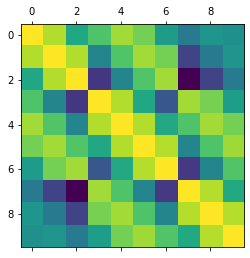

In [91]:
plt.matshow(covariance_matrix[310:320,310:320])

### Write verion of nll where the inegration is scs.norm.cdf and is done based on the blocks.

Take the wet days corresponding toa block together in a cdf with their appropriate subcovariance matrix, do that for each block and multiply the cdfs from each block together to get a mode independent version of the big integration.

Compare this blocked nll with the MC integration and classical.

Also try the MC nll with the blocking idea, and compare.

Looking for time improvement as well as accuracy.

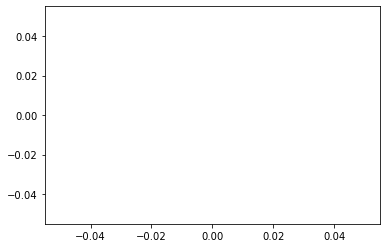

In [77]:
# This creates groups of indexes corresponding to correlated 'blocks' in the covariance/locations matrix
a = np.where(covariance_matrix[:1500,:1500]>0.1)
b = np.where([a[0]!=a[1]])
#c = np.nonzero(b)
c = [(a[0][i],a[1][i]) for i in b[1]]
pairs = list(set([tuple(sorted(c_)) for c_ in c]))
graph = nx.Graph()
graph.add_edges_from([pairs[i] for i in range(len(pairs)) if abs(pairs[i][0]-pairs[i][1])<17])
cor_blocks = []
for connected_component in nx.connected_components(graph):
    cor_blocks.append(list(connected_component))

plt.plot([len(cor_blocks[i]) for i in range(len(cor_blocks))])

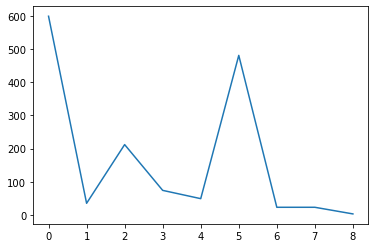

In [57]:
# This creates groups of indexes corresponding to correlated 'blocks' in the covariance/locations matrix
a = np.where(covariance_matrix[:1500,:1500]>0.1)
b = np.where([a[0]!=a[1]])
#c = np.nonzero(b)
c = [(a[0][i],a[1][i]) for i in b[1]]
pairs = list(set([tuple(sorted(c_)) for c_ in c]))
graph = nx.Graph()
graph.add_edges_from(pairs)
cor_blocks = []
for connected_component in nx.connected_components(graph):
    cor_blocks.append(list(connected_component))

plt.plot([len(cor_blocks[i]) for i in range(len(cor_blocks))])

In [21]:
[pairs[i] for i in range(len(pairs)) if abs(pairs[i][0]-pairs[i][1])<5]

[(177, 181),
 (67, 68),
 (99, 100),
 (70, 73),
 (118, 122),
 (159, 160),
 (8, 9),
 (40, 41),
 (100, 101),
 (132, 133),
 (73, 74),
 (133, 134),
 (14, 15),
 (15, 16),
 (96, 99),
 (107, 108),
 (188, 191),
 (48, 49),
 (80, 81),
 (140, 141),
 (81, 82),
 (25, 29),
 (173, 174),
 (22, 23),
 (55, 56),
 (59, 63),
 (147, 148),
 (92, 96),
 (33, 37),
 (181, 182),
 (125, 129),
 (84, 88),
 (66, 70),
 (176, 180),
 (158, 162),
 (117, 121),
 (99, 103),
 (40, 44),
 (150, 154),
 (113, 114),
 (132, 136),
 (91, 95),
 (25, 28),
 (32, 36),
 (165, 169),
 (14, 18),
 (124, 128),
 (87, 88),
 (17, 20),
 (179, 180),
 (65, 69),
 (28, 29),
 (88, 89),
 (157, 161),
 (120, 121),
 (6, 10),
 (139, 143),
 (180, 181),
 (50, 53),
 (98, 102),
 (61, 62),
 (80, 84),
 (121, 122),
 (39, 43),
 (153, 154),
 (172, 176),
 (131, 135),
 (24, 27),
 (3, 4),
 (35, 36),
 (95, 96),
 (127, 128),
 (9, 11),
 (187, 188),
 (36, 37),
 (68, 69),
 (128, 129),
 (160, 161),
 (69, 70),
 (101, 102),
 (161, 162),
 (31, 34),
 (10, 11),
 (32, 35),
 (194, 

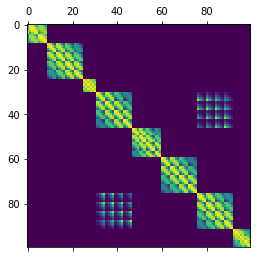

In [86]:
plt.matshow(covariance_matrix[1000:1100,1000:1100])

In [6]:
scs.multivariate_normal.cdf(x=inv_us[0][:16],mean=np.zeros(16),cov=covariance_matrix[:16,:16])

0.3877153280428165

In [5]:
#basic nll
#truncgauss(L=dist_mat).nll(theta=0.1,Invcdf_Us=[inv_us[i] for i in range(50)],truncation_pi=[g2_us[i] for i in range(50)],did_rain=[did_rain_01[i] for i in range(50)],len_locs=len(g2_us[0]),rvs = rand_vars) 
# locs:all , days:range(50) , theta:0.1 , time:3m28 , nll = -238511.6341627678

In [6]:
#nll on subsets of days
#truncgauss(L=dist_mat).nll_sub_days(days_list=range(50),Invcdf_Us=inv_us,truncation_pi=g2_us,did_rain=did_rain_01,len_locs=len(g2_us),rvs=rand_vars,cov_mat=covariance_matrix)
# locs:all , days:range(50) , theta:0.1 , time:1m30 + 25s , nll = -238511.6341627678

In [80]:
nll_sub_days(days_list=range(200,220),Invcdf_Us=inv_us,truncation_pi=g2_us,did_rain=did_rain_01,len_locs=len(g2_us),rvs=rand_vars,cov_mat=covariance_matrix)      

100%|██████████| 20/20 [01:07<00:00,  3.36s/it]


-76512.25997904879

### Trying mp
not working rn

In [15]:
def my_func(days_list):
    l = inv_us
    return np.sum([l[i] for i in days_list])

In [17]:
my_func(range(800))

2277931.990557351

In [18]:
def parallel_nll(theta):
    
    # Kernel
    cov_mat = covariance_matrix
    print('cov_mat')
    # parallel likelihood
    size = math.ceil(300/psutil.cpu_count())
    days_chuncks = [[i for i in range(300)][x:x+size] for x in range(0,300, size)]
    #list_nll = Parallel(n_jobs=psutil.cpu_count())(delayed(nll_sub_days)(chunck,inv_us,g2_us,did_rain_01,len(g2_us),rand_vars,cov_mat) for chunck in tqdm(days_chuncks))
    list_nll = Parallel(n_jobs=psutil.cpu_count())(delayed(my_func)(chunck) for chunck in tqdm(days_chuncks))

    return list_nll
    #return [size, len(days_chuncks[0])]




In [19]:
parallel_nll(0.1)   

cov_mat


100%|██████████| 8/8 [00:00<00:00, 3930.01it/s]
